In [0]:
from jax import jit, grad, vmap, random
from functools import partial
import jax
import jax.numpy as np
from jax.experimental import stax # neural network library
from jax.experimental.stax import Conv, Dense, MaxPool, Relu, Flatten, LogSoftmax, LeakyRelu, Dropout # neural network layers
import matplotlib.pyplot as plt # visualization
import numpy as onp
from jax.experimental import optimizers
from jax.tree_util import tree_multimap  # Element-wise manipulation of collections of numpy arrays 

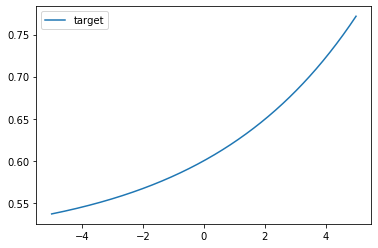

In [0]:
#Define inputs
xrange_inputs = np.linspace(-5,5,500).reshape((500, 1)) # (k, 1)
targets = (np.exp(0.2*xrange_inputs)+5.)/10
plt.plot(xrange_inputs, targets, label='target')
plt.legend()

In [0]:
#Network
rng = random.PRNGKey(1)
net_init, net_apply = stax.serial(
    Dense(50), LeakyRelu,
    Dense(10), Relu,
    Dense(5), Relu,
    Dense(1)
)

in_shape = (-1, 1,)
out_shape, net_params = net_init(rng, in_shape)

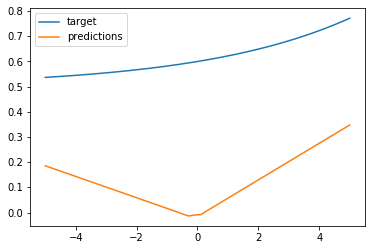

In [0]:
predictions = net_apply(net_params, xrange_inputs)
plt.plot(xrange_inputs, targets, label='target')
plt.plot(xrange_inputs, predictions, label='predictions')
plt.legend()

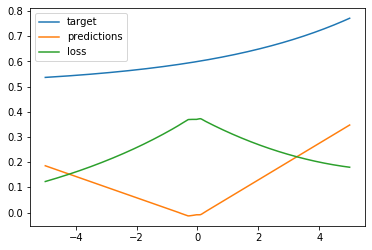

In [0]:
#Losses
def loss(params, inputs, targets):
    # Computes average loss for the batch
    predictions = net_apply(params, inputs)
    return np.mean((targets - predictions)**2)

losses = vmap(partial(loss, net_params))(xrange_inputs,targets)
plt.plot(xrange_inputs, targets, label='target')
plt.plot(xrange_inputs, predictions, label='predictions')
plt.plot(xrange_inputs, losses, label='loss')
plt.legend()

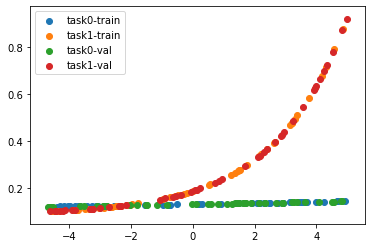

In [0]:
# Sampling datasets
def sample_tasks(outer_batch_size, inner_batch_size):
    # Select amplitude and phase for the task
    As = []
    phases = []
    for _ in range(outer_batch_size):        
        As.append(onp.random.uniform(low=0., high=10.))
        phases.append(onp.random.uniform(low=0., high=.5))
    def get_batch():
        xs, ys = [], []
        for A, phase in zip(As, phases):
            x = onp.random.uniform(low=-5., high=5., size=(inner_batch_size, 1))
            y = (A + onp.exp(x * phase))/10
            xs.append(x)
            ys.append(y)
        return np.stack(xs), np.stack(ys)
    x1, y1 = get_batch()
    x2, y2 = get_batch()
    return x1, y1, x2, y2

outer_batch_size = 2
x1, y1, x2, y2 = sample_tasks(outer_batch_size, 50)
for i in range(outer_batch_size):
    plt.scatter(x1[i], y1[i], label='task{}-train'.format(i))
for i in range(outer_batch_size):
    plt.scatter(x2[i], y2[i], label='task{}-val'.format(i))
plt.legend()

In [0]:
x2.shape

(2, 50, 1)

In [0]:
# Simple MAML Losses
alpha = .1
def inner_update(p, x1, y1):
    grads = grad(loss)(p, x1, y1)
    inner_sgd_fn = lambda g, state: (state - alpha*g)
    return tree_multimap(inner_sgd_fn, grads, p)

def maml_loss(p, x1, y1, x2, y2):
    p2 = inner_update(p, x1, y1)
    return loss(p2, x2, y2)

opt_init, opt_update, get_params = optimizers.adam(step_size=1e-3)  # this LR seems to be better than 1e-2 and 1e-4
out_shape, net_params = net_init(rng, in_shape)
opt_state = opt_init(net_params)

@jit
def step(i, opt_state, x1, y1, x2, y2):
    p = get_params(opt_state)
    g = grad(maml_loss)(p, x1, y1, x2, y2)
    l = maml_loss(p, x1, y1, x2, y2)
    return opt_update(i, g, opt_state), l
K=20
np_maml_loss = []

# Adam optimization for Simple MAML - The losses over tasks are not aggregated/batched
for i in range(100000):
    # define the task
    A = onp.random.uniform(low=0., high=10.)
    phase = onp.random.uniform(low=0., high=0.5)
    # meta-training inner split (K examples)
    x1 = onp.random.uniform(low=-5., high=5., size=(K,1))
    y1 = (A + onp.exp(x1 * phase))/10
    # meta-training outer split (1 example). Like cross-validating with respect to one example.
    x2 = onp.random.uniform(low=-5., high=5.)
    y2 = (A + onp.exp(x2 * phase))/10
    opt_state, l = step(i, opt_state, x1, y1, x2, y2)
    np_maml_loss.append(l)
    if i % 10000 == 0:
        print(i)
net_params = get_params(opt_state)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000


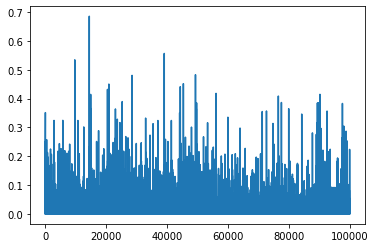

In [0]:
plt.plot(np_maml_loss)

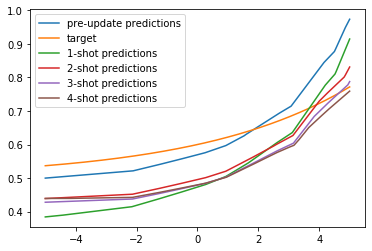

In [0]:
# batch the inference across K=100
targets = (5.+np.exp(xrange_inputs*0.2))/10
predictions = net_apply(net_params, xrange_inputs)
plt.plot(xrange_inputs, predictions, label='pre-update predictions')
plt.plot(xrange_inputs, targets, label='target')

x1 = onp.random.uniform(low=-5., high=5., size=(K,1))
y1 = (5. + onp.sin(x1 * 0.2))/10

for i in range(1,5):
    net_params = inner_update(net_params, x1, y1)
    # predictions = vmap(partial(net_apply, net_params))(xrange_inputs)
    predictions = net_apply(net_params, xrange_inputs)
    plt.plot(xrange_inputs, predictions, label='{}-shot predictions'.format(i))
plt.legend()

In [0]:
# Batched MAML Losses
opt_init, opt_update, get_params = optimizers.adam(step_size=1e-3)
out_shape, net_params = net_init(rng, in_shape)
opt_state = opt_init(net_params)

# vmapped version of maml loss.
# returns scalar for all tasks.
def batch_maml_loss(p, x1_b, y1_b, x2_b, y2_b):
    task_losses = vmap(partial(maml_loss, p))(x1_b, y1_b, x2_b, y2_b)
    return np.mean(task_losses)

@jit
def step(i, opt_state, x1, y1, x2, y2):
    p = get_params(opt_state)
    g = grad(batch_maml_loss)(p, x1, y1, x2, y2)
    l = batch_maml_loss(p, x1, y1, x2, y2)
    return opt_update(i, g, opt_state), l

np_batched_maml_loss = []
K=20
for i in range(100000):
    x1_b, y1_b, x2_b, y2_b = sample_tasks(4, K)
    opt_state, l = step(i, opt_state, x1_b, y1_b, x2_b, y2_b)
    np_batched_maml_loss.append(l)
    if i % 10000 == 0:
        print(i)
net_params = get_params(opt_state)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000


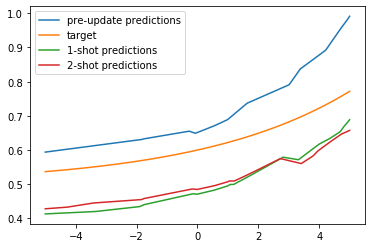

In [0]:
# batch the inference across K=100
targets = (5.+np.exp(xrange_inputs*0.2))/10
predictions = vmap(partial(net_apply, net_params))(xrange_inputs)
plt.plot(xrange_inputs, predictions, label='pre-update predictions')
plt.plot(xrange_inputs, targets, label='target')

x1 = onp.random.uniform(low=-5., high=5., size=(10,1))
y1 = (5. + onp.sin(x1 * 0.2))/10

for i in range(1,3):
    net_params = inner_update(net_params, x1, y1)
    predictions = vmap(partial(net_apply, net_params))(xrange_inputs)
    plt.plot(xrange_inputs, predictions, label='{}-shot predictions'.format(i))
plt.legend()

/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


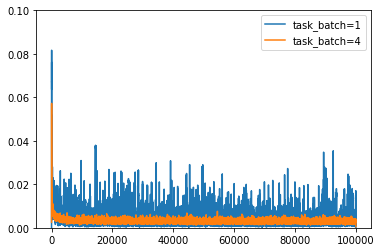

In [0]:
# Comparison of maml_loss for task batch size = 1 vs. task batch size = 8
plt.plot(onp.convolve(np_maml_loss, [.05]*20), label='task_batch=1')
plt.plot(onp.convolve(np_batched_maml_loss, [.05]*20), label='task_batch=4')
plt.ylim(0., 1e-1)
plt.legend()

In [0]:
print(np.average(np_maml_loss), np.average(np_batched_maml_loss))

0.00419467 0.0031060025
